# Self-driving car Nanodegree - Term 1

## Project 1: **Build a Traffic Sign Recognition Classifier**


## Load and Visualize The DataSet

### Sample Dataset Information

The [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) consists of 43 different traffic sign with each image having 32×32 px size. This dataset has 39,209 images as training data (Using this number of an image we have to train a neural network) and 12,630 images as a test data. Each image is a photo of one of the 43 class of traffic sign

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [1]:
# Load pickled data
import pickle
import pandas as pd
import numpy as np

# The data is probably in order RGB
training_file = '../../../train.p'
validation_file= '../../../valid.p'
testing_file = '../../../test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
ori_X_train, y_train = train['features'], train['labels']
ori_X_valid, y_valid = valid['features'], valid['labels']
ori_X_test, y_test = test['features'], test['labels']

# number of training examples
n_train = len(ori_X_train)

# Number of validation examples
n_validation = len(ori_X_valid)

# Number of testing examples.
n_test = len(ori_X_test)

# What's the shape of an traffic sign image?
image_shape = ori_X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
data = pd.read_csv('../signnames.csv')
n_classes = len(data)

# there are few ways to print tuple
print ('X_train shape is: {}'.format(ori_X_train.shape))
print('y_train shape is: %s' % y_train.shape)
print('X_valid shape is: ', ori_X_valid.shape)
print('y_valid shape is: ', y_valid.shape)
print('X_test shape is: ', ori_X_test.shape)
print('y_test shape is: ', y_test.shape)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


X_train shape is: (34799, 32, 32, 3)
y_train shape is: 34799
X_valid shape is:  (4410, 32, 32, 3)
y_valid shape is:  (4410,)
X_test shape is:  (12630, 32, 32, 3)
y_test shape is:  (12630,)
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

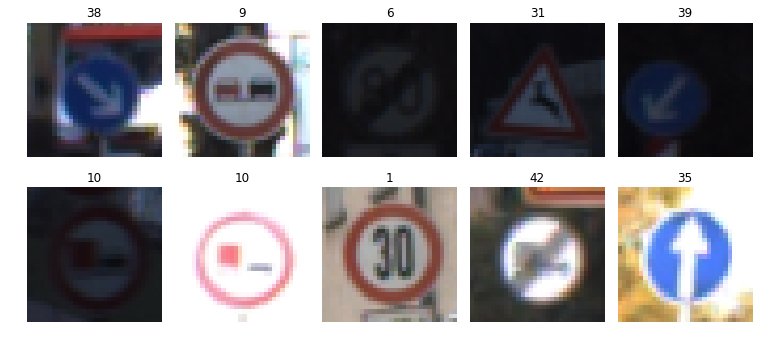

In [2]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

#plotting 10 randome traffic sign images
def plot_10_random_images(features, labels):
    fig, axes = plt.subplots(2, 5, figsize=(13, 6))
    fig.subplots_adjust(left=None, right=None,hspace = .02, wspace=0.1)
    for i in range(2):
        for j in range(5):
            randomindex = random.randint(0, len(features) - 1) 
            axes[i,j].axis('off')
            axes[i,j].imshow(features[randomindex])
            axes[i,j].set_title(labels[randomindex])

#plotting original data            
plot_10_random_images(ori_X_train, y_train)           
#plotting the count of each sign

----

## Step 2: Design and Test Classifier Model

#### Defining data pre-processing and evaluation functions

In [3]:
import cv2

#grayscale
def grayscale(input):
    output = []
    for i in range(len(input)): 
        img = cv2.cvtColor(input[i], cv2.COLOR_RGB2GRAY)
        output.append(img) 
    return output

# normalization
def normalization(input):
    output = []
    for i in range(len(input)): 
        img = (input[i] - 128)/128
        output.append(img) 
    return output

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Designing Clasifier Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### First attempt

My first attempt was to try the famous Lenet-5 model

![LeNet Architecture](../../img/lenet.png)
Source: Yan LeCun

**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

**Output**
Return the result of the 2nd fully connected layer.

In [6]:
from tensorflow.contrib.layers import flatten
import tensorflow as tf
from sklearn.utils import shuffle

''' Summary of first attempt 
Step 1: Pre-processing data 
    - graysclale 
    - normalize
    - reshape input data to (32,32,1)
Step 2: Define Lenet_5 model , also my initial learning rate was 0.001
Step 3: Train original Lenet_5 with train and validation sets
'''

"""STEP 1"""
gray_X_train = grayscale(ori_X_train)
gray_X_valid = grayscale(ori_X_valid)
gray_X_test = grayscale(ori_X_test)

normalized_X_train = normalization(gray_X_train)
normalized_X_valid = normalization(gray_X_valid)
normalized_X_test = normalization(gray_X_test)

final_X_train = np.expand_dims(normalized_X_train,3) 
final_X_valid = np.expand_dims(normalized_X_valid,3)
final_X_test = np.expand_dims(normalized_X_test,3)  


"""STEP 2"""
def Lenet_5(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #  Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

"""STEP 3"""

# parameters
EPOCHS = 20
BATCH_SIZE = 128
rate = 0.001

#placeholder :Inserts a placeholder for a tensor that will be always fed.
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

logits = Lenet_5(x)

#Computes softmax cross entropy between logits and labels.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

#Computes the mean of elements across dimensions of a tensor, this is training loss
loss_operation = tf.reduce_mean(cross_entropy)

# adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#tf.equal: Returns the truth value of (x == y) element-wise.
#tf.argmax: Returns the index with the largest value across axes of a tensor. 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

#Start running tensor flow
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(final_X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        #Shuffle before training
        X_train, y_train = shuffle(final_X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(final_X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.646

EPOCH 2 ...
Validation Accuracy = 0.034

EPOCH 3 ...
Validation Accuracy = 0.054

EPOCH 4 ...
Validation Accuracy = 0.054

EPOCH 5 ...
Validation Accuracy = 0.034

EPOCH 6 ...
Validation Accuracy = 0.054

EPOCH 7 ...
Validation Accuracy = 0.034

EPOCH 8 ...
Validation Accuracy = 0.054

EPOCH 9 ...
Validation Accuracy = 0.054

EPOCH 10 ...
Validation Accuracy = 0.034

EPOCH 11 ...
Validation Accuracy = 0.048

EPOCH 12 ...
Validation Accuracy = 0.034

EPOCH 13 ...
Validation Accuracy = 0.034

EPOCH 14 ...
Validation Accuracy = 0.034

EPOCH 15 ...
Validation Accuracy = 0.034

EPOCH 16 ...
Validation Accuracy = 0.054

EPOCH 17 ...
Validation Accuracy = 0.034

EPOCH 18 ...
Validation Accuracy = 0.054

EPOCH 19 ...
Validation Accuracy = 0.034

EPOCH 20 ...
Validation Accuracy = 0.034

Model saved


#### Second attempt

The first attempt gave a very low accuracy. In second attempt, I decided not to grayscale the image and keep 3 aolor dimensions with the same Lenet_5 model

In [ ]:
from tensorflow.contrib.layers import flatten
import tensorflow as tf
from sklearn.utils import shuffle

''' Summary of first attempt 
Step 1: Pre-processing data : nothing
Step 2: Re-define Lenet_5 model
Step 3: Train original Lenet_5 with train and validation sets
'''

"""STEP 1"""
# nothing here, 

"""STEP 2"""
# Redefine the model since the input now is 32x32x3
def Lenet_5(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #  Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

"""STEP 3"""

# parameters
EPOCHS = 10
BATCH_SIZE = 128
rate = 0.00

#placeholder :Inserts a placeholder for a tensor that will be always fed.
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

logits = Lenet_5(x)

#Computes softmax cross entropy between logits and labels.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

#Computes the mean of elements across dimensions of a tensor, this is training loss
loss_operation = tf.reduce_mean(cross_entropy)

# adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#tf.equal: Returns the truth value of (x == y) element-wise.
#tf.argmax: Returns the index with the largest value across axes of a tensor. 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

#Start running tensor flow
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(gray_X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(gray_X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")


### Evaluate the Model


In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")